In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import files

# Upload the Excel file
uploaded = files.upload()


Saving Bikroy.csv to Bikroy.csv


**Import Dataset and PreProcessing**

In [ ]:
# Try reading the CSV file with different encodings
encodings = ['utf-8', 'latin-1', 'ISO-8859-1']

for encoding in encodings:
    try:
        df = pd.read_csv('Bikroy.csv', encoding=encoding)
        # If successful, break out of the loop
        break
    except UnicodeDecodeError:
        print(f"Failed to decode using {encoding} encoding. Trying another encoding...")

Failed to decode using utf-8 encoding. Trying another encoding...


In [ ]:
columns_to_drop = ['userName','userImage', 'thumbsUpCount', 'reviewCreatedVersion','at','repliedAt','appVersion','translatedContent','content']
df = df.drop(columns=columns_to_drop)

# Display the first few rows of the updated DataFrame
df.head()

,reviewId,score,replyContent,userEngagement,Usability,processedContent
0,0,5,NaN,0,Positive,good one
1,1,5,NaN,0,Positive,Really Good
2,2,5,NaN,0,Positive,nice app
3,3,5,NaN,0,Positive,Alhamdulillah
4,4,5,NaN,0,Positive,nice app


In [ ]:
df['replyContent'].fillna('', inplace=True)  # Replace NaN with an empty string
df.head()

,reviewId,score,replyContent,userEngagement,Usability,processedContent
0,0,5,,0,Positive,good one
1,1,5,,0,Positive,Really Good
2,2,5,,0,Positive,nice app
3,3,5,,0,Positive,Alhamdulillah
4,4,5,,0,Positive,nice app


In [ ]:
ax = df["score"].value_counts().sort_index()

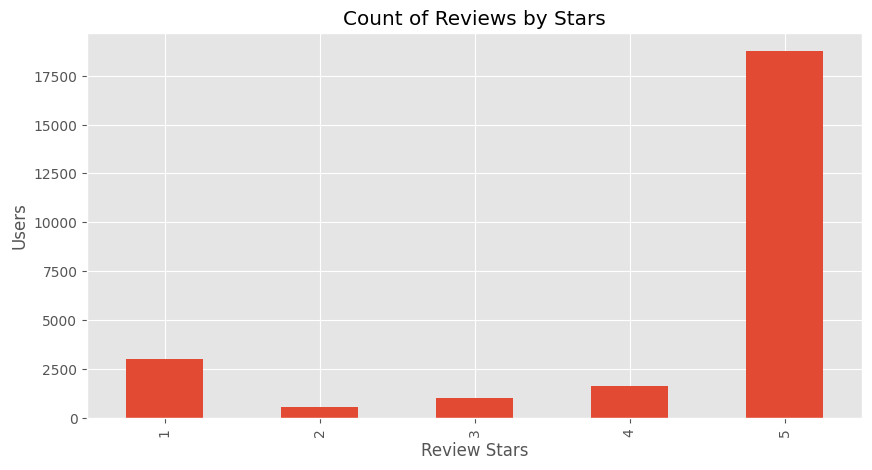

In [ ]:
ax = df["score"].value_counts().sort_index().plot(kind="bar", title="Count of Reviews by Stars", figsize=(10,5))

ax.set_xlabel('Review Stars')
ax.set_ylabel('Users')
plt.savefig('stars.pdf')
plt.show()

In [ ]:
# Get descriptive statistics:
df["Usability"].describe()

# Check for missing values:
df["Usability"].isnull().sum()


0

# **Models**

**Distillbert**

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

In [ ]:
res = {}
pipeline_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = str(row['processedContent'])
    myid = i
    pipeline_result = sent_pipeline(text)
    for key,value in pipeline_result[0].items():
        pipeline_result_rename[f'pipeline_{key}'] = value
    res[myid] = pipeline_result_rename.copy()

100%|██████████| 24953/24953 [17:01<00:00, 24.43it/s]


In [ ]:
# results_df2 = pd.DataFrame(res).T
# results_df2= results_df2.reset_index().rename(columns={"index":"reviewId"})

# df['pipeline_label'] = df['reviewId'].str.split('_').str[1]
# # df['pipeline_label'] = df['pipeline_label'].astype('int64')
# df = df.dropna()
# results_df2 = results_df2.merge(df, how="left")

results_df2 = pd.DataFrame(res).T.reset_index().rename(columns={"index": "reviewId"})

# Convert 'reviewId' column to string in both DataFrames
results_df2['reviewId'] = results_df2['reviewId'].astype(str)
df['reviewId'] = df['reviewId'].astype(str)

# Merge the sentiment analysis results with the original DataFrame

In [ ]:
print("Results DataFrame:")
print(results_df2.head())

print("\nOriginal DataFrame:")
print(df.head())

# Merge the sentiment analysis results with the original DataFrame
merged_df = pd.merge(results_df2, df, on="reviewId", how="left")

print("\nMerged DataFrame:")
print(merged_df.head())

Results DataFrame:
  reviewId pipeline_label pipeline_score
0        0       POSITIVE       0.999829
1        1       POSITIVE       0.999851
2        2       POSITIVE       0.999806
3        3       POSITIVE        0.89034
4        4       POSITIVE       0.999806

Original DataFrame:
  reviewId  score replyContent  userEngagement Usability processedContent
0        0      5                            0  Positive         good one
1        1      5                            0  Positive      Really Good
2        2      5                            0  Positive         nice app
3        3      5                            0  Positive    Alhamdulillah
4        4      5                            0  Positive         nice app

Merged DataFrame:
  reviewId pipeline_label pipeline_score  score replyContent  userEngagement  \
0        0       POSITIVE       0.999829      5                            0   
1        1       POSITIVE       0.999851      5                            0   
2        2 

In [ ]:
pos_reviews = merged_df[merged_df.pipeline_label == 'POSITIVE']
neg_reviews = merged_df[merged_df.pipeline_label == 'NEGATIVE']

print("Number of positive reviews:", pos_reviews.shape[0])
print("Number of negative reviews:", neg_reviews.shape[0])

neg_reviews = neg_reviews[neg_reviews.score < 4]
pos_reviews = pos_reviews[pos_reviews.score > 3]

print("Number of filtered positive reviews:", pos_reviews.shape[0])
print("Number of filtered negative reviews:", neg_reviews.shape[0])

distilbert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df2.shape[0]
print("Accuracy:", distilbert_accuracy)

Number of positive reviews: 20153
Number of negative reviews: 4800
Number of filtered positive reviews: 18417
Number of filtered negative reviews: 2837
Accuracy: 0.8517613112651785


In [ ]:
neg_reviews = neg_reviews[neg_reviews.score <4]
pos_reviews = pos_reviews[pos_reviews.score >3]
distilbert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df2.shape[0]

In [ ]:
print(pos_reviews)

      reviewId pipeline_label pipeline_score  score replyContent  \
0            0       POSITIVE       0.999829      5                
1            1       POSITIVE       0.999851      5                
2            2       POSITIVE       0.999806      5                
3            3       POSITIVE        0.89034      5                
4            4       POSITIVE       0.999806      5                
...        ...            ...            ...    ...          ...   
24948    24948       POSITIVE       0.937861      5   Thank you.   
24949    24949       POSITIVE       0.999565      5   Thank you.   
24950    24950       POSITIVE       0.999867      5   Thank you.   
24951    24951       POSITIVE       0.999872      5   Thank you.   
24952    24952       POSITIVE       0.999681      5   Thank you.   

       userEngagement Usability  \
0                   0  Positive   
1                   0  Positive   
2                   0  Positive   
3                   0  Positive   
4       

In [ ]:
neg_reviews = merged_df[merged_df.pipeline_label == 'NEGATIVE']
pos_reviews = merged_df[merged_df.pipeline_label == 'POSITIVE']

In [ ]:
print(pos_reviews)

      reviewId pipeline_label pipeline_score  score replyContent  \
0            0       POSITIVE       0.999829      5                
1            1       POSITIVE       0.999851      5                
2            2       POSITIVE       0.999806      5                
3            3       POSITIVE        0.89034      5                
4            4       POSITIVE       0.999806      5                
...        ...            ...            ...    ...          ...   
24948    24948       POSITIVE       0.937861      5   Thank you.   
24949    24949       POSITIVE       0.999565      5   Thank you.   
24950    24950       POSITIVE       0.999867      5   Thank you.   
24951    24951       POSITIVE       0.999872      5   Thank you.   
24952    24952       POSITIVE       0.999681      5   Thank you.   

       userEngagement Usability  \
0                   0  Positive   
1                   0  Positive   
2                   0  Positive   
3                   0  Positive   
4       

In [ ]:
precision_pos_reviews = pos_reviews[pos_reviews.score < 4]

print(precision_pos_reviews)

distilbert_precision = pos_reviews.shape[0]/(precision_pos_reviews.shape[0]+pos_reviews.shape[0])

      reviewId pipeline_label pipeline_score  score  \
7            7       POSITIVE       0.999826      1   
18          18       POSITIVE       0.999855      3   
35          35       POSITIVE       0.898614      1   
46          46       POSITIVE       0.999848      3   
52          52       POSITIVE       0.999816      3   
...        ...            ...            ...    ...   
24699    24699       POSITIVE       0.999854      3   
24707    24707       POSITIVE       0.980708      2   
24752    24752       POSITIVE       0.990715      1   
24910    24910       POSITIVE       0.999875      3   
24916    24916       POSITIVE       0.999848      3   

                                            replyContent  userEngagement  \
7      Thanks for the review. If you like our app, we...               1   
18     Thanks for the review. If you like our app, we...               1   
35     Sorry for the bad experience with the app. Ple...               1   
46     Thanks for the review. If yo

In [ ]:
recall_neg_reviews = neg_reviews[neg_reviews.score >3]
distilbert_recall = (neg_reviews.shape[0] + pos_reviews.shape[0])/(recall_neg_reviews.shape[0]+(neg_reviews.shape[0] + pos_reviews.shape[0]))

In [ ]:
distilbert_f1_Score = 2 * (distilbert_precision * distilbert_recall) / (distilbert_precision + distilbert_recall)

In [ ]:
print("DistilBERT accuracy: " + str(distilbert_accuracy))
print("DistilBERT Precision: " + str(distilbert_precision))
print("DistilBERT Recall: " + str(distilbert_recall))
print("DistilBERT F1 Score: " + str(distilbert_f1_Score))

DistilBERT accuracy: 0.8517613112651785
DistilBERT Precision: 0.9206907579149345
DistilBERT Recall: 0.9270694010997177
DistilBERT F1 Score: 0.9238690696669308


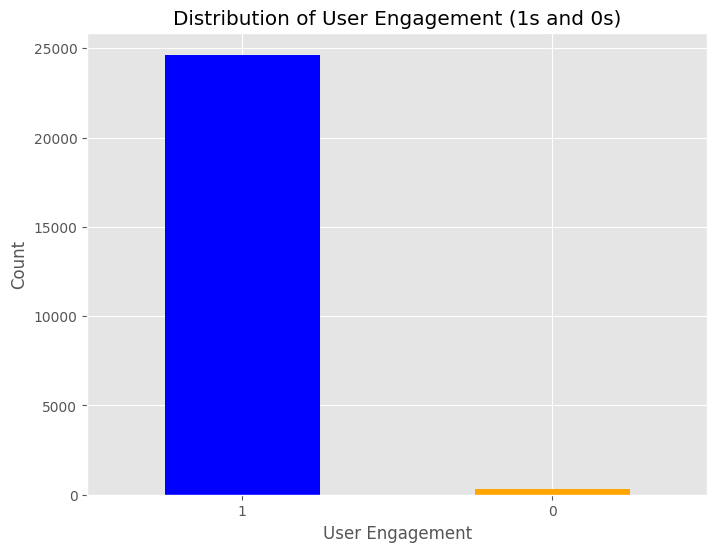

Average User Engagement: 0.9876167194325332


In [ ]:
import matplotlib.pyplot as plt
engagement_counts = merged_df['userEngagement'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
engagement_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of User Engagement (1s and 0s)')
plt.xlabel('User Engagement')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Calculate and print the average user engagement
average_engagement = merged_df['userEngagement'].mean()
print(f'Average User Engagement: {average_engagement}')

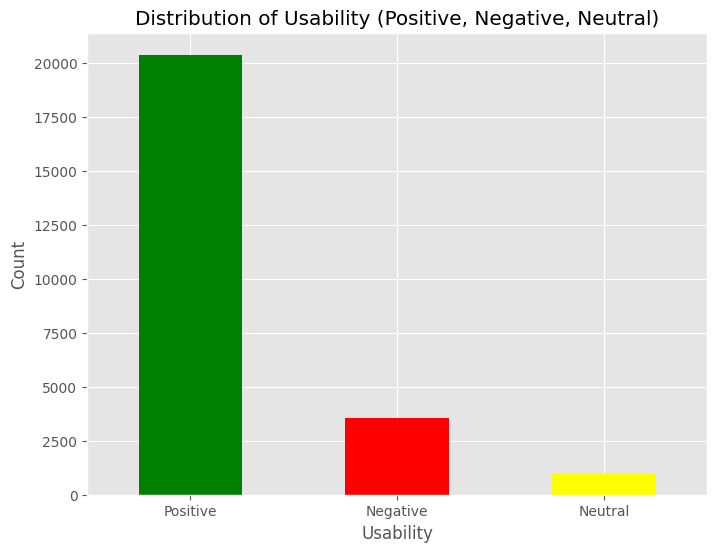

In [ ]:
usability_counts = merged_df['Usability'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
usability_counts.plot(kind='bar', color=['green', 'red', 'yellow'])
plt.title('Distribution of Usability (Positive, Negative, Neutral)')
plt.xlabel('Usability')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.5 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()  # Instantiate the analyzer

In [ ]:
res = {}
vader_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
  text = str(row['processedContent'])
  myid = i
  vader_result = sia.polarity_scores(text)
  for key,value in vader_result.items():
    vader_result_rename[f'vader_{key}'] = value
  roberta_result = polarity_scores_roberta(text)
  both = {**vader_result_rename, **roberta_result}
  res[myid] = both

100%|██████████| 24953/24953 [35:02<00:00, 11.87it/s]


In [ ]:
results_df = pd.DataFrame(res).T.reset_index().rename(columns={"index": "reviewId"})

# Convert 'reviewId' column to string in both DataFrames
results_df['reviewId'] = results_df['reviewId'].astype(str)
df['reviewId'] = df['reviewId'].astype(str)

In [ ]:
print("Results DataFrame:")
print(results_df.head())

print("\nOriginal DataFrame:")
print(df.head())

# Merge the sentiment analysis results with the original DataFrame
merged_df2 = pd.merge(results_df, df, on="reviewId", how="left")

print("\nMerged DataFrame:")
print(merged_df2.head())

Results DataFrame:
  reviewId  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        0        0.0      0.256      0.744          0.4404     0.015318   
1        1        0.0      0.238      0.762          0.4927     0.005314   
2        2        0.0      0.263      0.737          0.4215     0.010883   
3        3        0.0      1.000      0.000          0.0000     0.043890   
4        4        0.0      0.263      0.737          0.4215     0.010883   

   roberta_neu  roberta_pos  
0     0.139719     0.844964  
1     0.069663     0.925024  
2     0.083239     0.905878  
3     0.646706     0.309404  
4     0.083239     0.905878  

Original DataFrame:
  reviewId  score replyContent  userEngagement Usability processedContent
0        0      5                            0  Positive         good one
1        1      5                            0  Positive      Really Good
2        2      5                            0  Positive         nice app
3        3      5          

In [ ]:
tp = 0
for i, row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive, negative, neutral) == positive and (row["score"] == 4 or row["score"] == 5)):
    tp += 1
  elif(max(positive, negative, neutral) == neutral and row["score"] == 3):
    tp += 1
  elif(max(positive, negative, neutral) == negative and (row["score"] == 1 or row["score"] == 2)):
    tp += 1

roberta_accuracy = (tp) / (merged_df2.shape[0])

In [ ]:
tp = 0
fp = 0
for i,row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["score"]==4 or row["score"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["score"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["score"]==1 or row["score"]==2):
    tp+=1
  elif(max(positive,negative,neutral) == positive and row["score"]<4):
    fp+=1
roberta_precision = (tp)/(tp+fp)

In [ ]:
tp = 0
fn = 0
for i,row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["score"]==4 or row["score"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["score"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["score"]==1 or row["score"]==2):
    tp+=1
  if(max(positive,negative,neutral) == negative and row["score"]>2):
    fn+=1
  if(max(positive,negative,neutral) == negative and row["score"]!=3):
    fn+=1

roberta_recall = (tp)/(tp+fn)

In [ ]:
roberta_f1_Score = 2 * (roberta_precision * roberta_recall) / (roberta_precision + roberta_recall)

In [ ]:
print("Roberta accuracy: " + str(roberta_accuracy))
print("Roberta Precision: " + str(roberta_precision))
print("Roberta Recall: " + str(roberta_recall))
print("Roberta F1 Score: " + str(roberta_f1_Score))

Roberta accuracy: 0.6979521500420791
Roberta Precision: 0.9596854340405306
Roberta Recall: 0.9005027570548167
Roberta F1 Score: 0.9291526345514255
